In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-25 16:10:20,696 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
#             yt = np.array(y.loc[:, col], dtype=float)
#             yp = np.array(y_pred.loc[:, col], dtype=float)
            yt = y.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
                ss_tot = spst.circvar(yt, low=-np.pi / 2, high=np.pi / 2)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_cost': best_cost,
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
#         row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shape6fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 32 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,False,6.106395,603.584757,12-005_C__shape6fit-swarm_2018-04-24_21-10-26....,../../results/shape6fit,C,9,0.064433,-0.717454,-1.607310,0.153936,12-005
1,False,5.778795,451.020868,12-005_C__shape6fit-swarm_2018-04-24_21-20-33....,../../results/shape6fit,C,9,0.378660,-0.548739,-1.768935,0.160219,12-005
2,False,5.636891,1280.200945,12-005_C__shape6fit-swarm_2018-04-24_21-28-08....,../../results/shape6fit,C,9,0.214172,-0.407974,-1.533532,0.090443,12-005
3,False,6.083982,1014.430015,12-005_C__shape6fit-swarm_2018-04-24_23-09-42....,../../results/shape6fit,C,9,0.077963,-0.713971,-1.601006,0.153033,12-005
4,False,6.052559,321.257416,12-005_C__shape6fit-swarm_2018-04-24_23-26-47....,../../results/shape6fit,C,9,0.232753,-0.767385,-1.674748,0.156821,12-005
5,False,6.230041,913.237516,12-005_C__shape6fit-swarm_2018-04-24_23-32-22....,../../results/shape6fit,C,9,0.400861,-0.957017,-1.846507,0.172622,12-005
6,False,6.057170,1260.491670,12-005_C__shape6fit-swarm_2018-04-24_23-47-45....,../../results/shape6fit,C,9,0.202379,-0.761599,-1.655121,0.157172,12-005
7,False,6.012244,955.937630,12-005_C__shape6fit-swarm_2018-04-25_00-08-55....,../../results/shape6fit,C,9,0.302642,-0.772837,-1.703761,0.161712,12-005
8,False,6.026749,694.128734,12-005_C__shape6fit-swarm_2018-04-25_00-25-04....,../../results/shape6fit,C,9,-0.111207,-0.449216,-1.606300,0.139974,12-005
9,False,5.775630,909.657389,12-005_C__shape6fit-swarm_2018-04-25_00-36-51....,../../results/shape6fit,C,9,0.332584,-0.498933,-1.754028,0.144747,12-005


In [6]:
data.n_samples.unique()

array([ 9, 15,  8])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime', 'best_cost'].agg(['mean', 'std', 'count'])

exetime                      best_cost  \
                                  mean          std count        mean   
subject model adjust_bias                                               
12-005  C     False         807.911114   291.174867    13    6.054068   
51-009  C     False        6043.991203  5021.971461     3  979.143874   
52-001  C     False        1819.135193   727.879534     3    3.294257   
TB      C     False        1778.703957   871.656117    13    4.808000   

                                             
                                  std count  
subject model adjust_bias                    
12-005  C     False          0.249531    13  
51-009  C     False        839.869965     3  
52-001  C     False          0.104816     3  
TB      C     False          0.269922    13

# The best runs in their respective category

In [9]:
# 51-009
# Best err: 7.80698395097 Best params: {
#     'implant_x': -799.1442217201959, 
#     'loc_od_y': 0.7546936471295187, 
#     'rho': 50.0, 
#     'loc_od_x': 15.654335316168801, 
#     'implant_rot': -1.0921220639722116, 
#     'axlambda': 1103.7970402031128, 
#     'implant_y': 92.753210211560955}

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols).min()

Best scores:


,,,best_cost,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,
12-005,C,False,5.636891,0.214172,-0.407974,-1.533532,0.090443
51-009,C,False,9.345927,0.795856,-5.525148,-1.118977,0.502343
52-001,C,False,3.228239,0.005138,-0.163507,0.311080,0.619050
TB,C,False,4.508005,-0.981647,-0.231006,0.085179,0.619470


# Runs that give sufficiently good results

Predicts all four parameters:

In [11]:
best = data.loc[best_idx, :]
best4_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best4_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

""


Predicts at least 3 out of 4:

In [12]:
best3_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_eccentricity'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best3_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
52-001,C,False,3.228239,52-001_C__shape6fit-swarm_2018-04-24_21-54-29....,0.005138,-0.163507,0.31108,0.61905


Predicts at least 2 out of 4:

In [13]:
best2_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best2_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
12-005,C,False,5.636891,12-005_C__shape6fit-swarm_2018-04-24_21-28-08....,0.214172,-0.407974,-1.533532,0.090443
51-009,C,False,9.345927,51-009_C__shape6fit-swarm_2018-04-25_10-18-58....,0.795856,-5.525148,-1.118977,0.502343
52-001,C,False,3.228239,52-001_C__shape6fit-swarm_2018-04-24_21-54-29....,0.005138,-0.163507,0.311080,0.619050
TB,C,False,4.508005,TB_C__shape6fit-swarm_2018-04-24_23-40-46.pickle,-0.981647,-0.231006,0.085179,0.619470


In [14]:
best1_idx = (best['r2_area'] > 0)
best1_idx |= (best['r2_compactness'] > 0)
best1_idx |= (best['r2_eccentricity'] > 0)
best1_idx |= (best['r2_orientation'] > 0)
best.loc[best1_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
12-005,C,False,5.636891,12-005_C__shape6fit-swarm_2018-04-24_21-28-08....,0.214172,-0.407974,-1.533532,0.090443
51-009,C,False,9.345927,51-009_C__shape6fit-swarm_2018-04-25_10-18-58....,0.795856,-5.525148,-1.118977,0.502343
52-001,C,False,3.228239,52-001_C__shape6fit-swarm_2018-04-24_21-54-29....,0.005138,-0.163507,0.311080,0.619050
TB,C,False,4.508005,TB_C__shape6fit-swarm_2018-04-24_23-40-46.pickle,-0.981647,-0.231006,0.085179,0.619470


In [15]:
plot_files = best.loc[best1_idx, :].reset_index()

In [16]:
# plot_files = best.reset_index()[best.reset_index()['subject'] == '12-005']

In [17]:
y, _, best_params, _ = pickle.load(open(os.path.join(*plot_files.loc[plot_files.index[0], ['filepath', 'filename']]), 'rb'))
if isinstance(y, list):
    y = pd.concat(y)
columns = y.drop(columns=['electrode', 'image']).columns
columns

Index(['area', 'compactness', 'eccentricity', 'orientation'], dtype='object')

In [18]:
best_params

{'axlambda': 355.82349108664039, 'rho': 375.87554919140825}

# Plot best ones

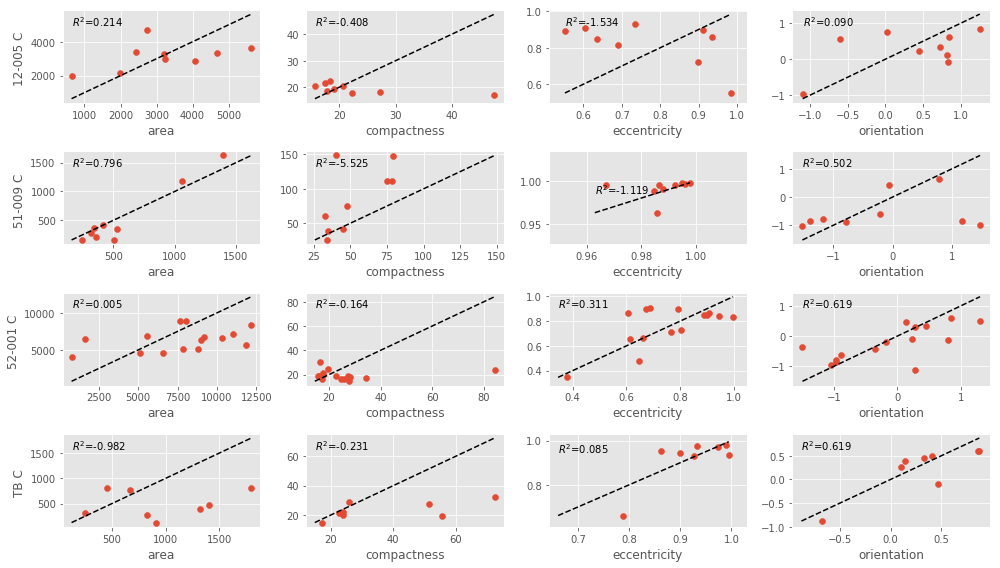

In [19]:
fig, axes = plt.subplots(ncols=len(columns), nrows=np.maximum(2, len(plot_files)), 
                         figsize=(14, 2 * np.maximum(2, len(plot_files))))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    if row['model'] != 'C':
        continue
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    if isinstance(y, list):
        y = pd.concat(y)
        y_pred = pd.concat(y_pred)
    idx = y['electrode'] == 'D017'
#     idx = np.logical_or(idx, y['electrode'] == 'B03')
#     idx = np.logical_or(idx, y['electrode'] == 'C08')
#     idx = np.logical_or(idx, y['electrode'] == 'E09')
    y = y[np.logical_not(idx)]
    y_pred = y_pred[np.logical_not(idx)]
    row['r2_area'] = sklm.r2_score(y['area'], np.nan_to_num(y_pred['area']))
    row['r2_compactness'] = sklm.r2_score(y['compactness'], np.nan_to_num(y_pred['compactness']))
    row['r2_eccentricity'] = sklm.r2_score(y['eccentricity'], np.nan_to_num(y_pred['eccentricity']))
    err = np.abs(y['orientation'] - np.nan_to_num(y_pred['orientation']))
    err = np.where(err > np.pi / 2, np.pi - err, err)
    # Use circular variance in `ss_tot`, which divides by len(yt).
    # Therefore, we also need to divide `ss_res` by len(yt), which
    # is the same as taking the mean instead of the sum.
    ss_res = np.mean(err ** 2)
    # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    ss_tot = spst.circvar(y['orientation'], low=-np.pi / 2, high=np.pi / 2)
    row['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
                
    cond = y_pred['orientation'] > 0.7
#     print(y[cond], y_pred[cond])
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
#     break
fig.tight_layout()

In [20]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [21]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [22]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
           df        sum_sq        mean_sq         F    PR(>F)
y_hat     1.0  4.533999e+04   45339.992017  0.147734  0.713964
Residual  6.0  1.841422e+06  306903.584664       NaN       NaN

compactness
           df       sum_sq      mean_sq         F    PR(>F)
y_hat     1.0  1098.763546  1098.763546  3.755796  0.100723
Residual  6.0  1755.308820   292.551470       NaN       NaN

eccentricity
           df    sum_sq   mean_sq         F    PR(>F)
y_hat     1.0  0.021095  0.021095  9.220931  0.022903
Residual  6.0  0.013726  0.002288       NaN       NaN

orientation
           df    sum_sq   mean_sq          F    PR(>F)
y_hat     1.0  1.197017  1.197017  14.218218  0.009281
Residual  6.0  0.505134  0.084189        NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
